In [15]:
# Установить зависимости
%pip install -U scikit-learn pandas matplotlib lightgbm imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33510 entries, 0 to 33509
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           33510 non-null  int64 
 1   cuisine      33510 non-null  object
 2   ingredients  33510 non-null  object
dtypes: int64(1), object(2)
memory usage: 785.5+ KB
      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  22213       indian                [water, vegetable oil, wheat, salt]
3  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
4   3735      italian  [sugar, pistachio nuts, white almond bark, flo...


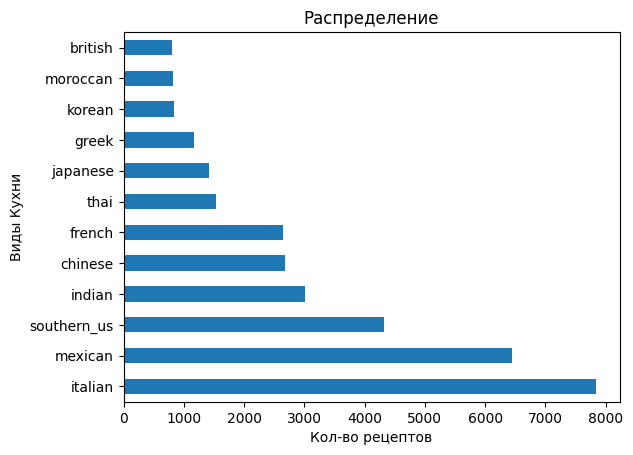

d:\Dev\DataSciencePro\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:58:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimatiors", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Dev\DataSciencePro\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:59:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimatiors", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Dev\DataSciencePro\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:59:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimatiors", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Dev\DataSciencePro\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:59:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Para

Метрики качества:
              precision    recall  f1-score   support

     british       0.72      0.70      0.71       161
     chinese       0.79      0.77      0.78       161
      french       0.59      0.71      0.64       161
       greek       0.85      0.79      0.82       161
      indian       0.81      0.86      0.83       161
     italian       0.76      0.78      0.77       161
    japanese       0.81      0.70      0.75       161
      korean       0.87      0.86      0.87       161
     mexican       0.91      0.86      0.89       161
    moroccan       0.86      0.90      0.88       161
 southern_us       0.76      0.76      0.76       161
        thai       0.89      0.87      0.88       161

    accuracy                           0.80      1932
   macro avg       0.80      0.80      0.80      1932
weighted avg       0.80      0.80      0.80      1932

Точность модели: 0.80


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Прочитать датасет из JSON файла
df = pd.read_json('HW1_1_dataset.zip')

# Вывод инфы про столбцы, недостающие значения, типы данных, а также несколько первых записей
df.info()
print(df.head())

# График распределения кухонь
cuisine_plt = df['cuisine'].value_counts().plot(kind='barh', title='Распределение', xlabel='Кол-во рецептов', ylabel='Виды Кухни')
plt.show()

# Удалить ненужный столбец id (axis=1 - столбец) и преобразовать массив строк в одну строку
df.drop("id", axis=1, inplace=True)
df['ingredients'] = df['ingredients'].apply(lambda x: ' '.join(x))

# Признаки (X) - токинизированный перечень ингрииентов, целевая переменная (y) - тип кухни
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['ingredients']).toarray()
y = df['cuisine']

# Разделить на тренировочкую (80%) и тестовую выборки (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Балансируем классы через андерсэмплер
res = RandomUnderSampler(sampling_strategy='all', random_state=42)

X_train, y_train = res.fit_resample(X_train, y_train)
X_test, y_test = res.fit_resample(X_test, y_test)

# Тренируем модель
classifier = StackingClassifier(estimators=[
   ('xg', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimatiors=1000, max_depth=6, learning_rate=0.5, random_state=42)),
   ('lgbm', LGBMClassifier(learning_rate=0.1, verbosity=-1)),
   ('forest', RandomForestClassifier(n_estimators=100, random_state=42))
], final_estimator=LogisticRegression(max_iter=1000, random_state=42))

classifier.fit(X_train, y_train)

# Предсказываем
y_pred = classifier.predict(X_test)

# Проверка и анализ результатов
print('Метрики качества:')
print(classification_report(y_test, y_pred))
print(f"Точность модели: {accuracy_score(y_test, y_pred):.2f}")